In [1]:
import sys
sys.path.append('/kaggle/input/efficientnetv2-pretrained-imagenet21k-weights/brain_automl/')
sys.path.append('/kaggle/input/efficientnetv2-pretrained-imagenet21k-weights/brain_automl/efficientnetv2/')

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from multiprocessing import cpu_count

import imageio
import cv2
import os
import glob
import math
import time
import pickle
import gc
import joblib
import sys
import effnetv2_model

print(f'tensorflow version: {tf.__version__}')
print(f'tensorflow keras version: {tf.keras.__version__}')
print(f'python version: P{sys.version}')

tensorflow version: 2.6.2
tensorflow keras version: 2.6.0
python version: P3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


In [4]:
# Model Configuration
EFNV2_SIZE = 's'
IMG_SIZE = 640
N_CHANNELS = 3

# Image Dimensions
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, N_CHANNELS)
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
SEED = 42

# Percentile to introduce new individual class to prediction
NEW_INDIVIDUAL_PERCENTILE = 35

TTA = 1
DOLG_SIZE = 1024
EMBEDDING_SIZE = 2048

RECOMPUTE_EMBEDDINGS = True

IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

EPS = tf.keras.backend.epsilon()

2022-04-09 00:07:41.733147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 00:07:41.822576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 00:07:41.823388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 00:07:41.827687: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Hardware Configuration

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on GPU
REPLICAS: 1


# DOLG

DOLG: Single-Stage Image Retrieval with Deep Orthogonal Fusion of Local and Global Features ([paper](https://arxiv.org/pdf/2108.02927.pdf))

Implementation based on the [DOLG Pytorch implementation](https://github.com/ChristofHenkel/kaggle-landmark-2021-1st-place/blob/main/models/ch_mdl_dolg_efficientnet.py) by [Christof Henkel](https://www.kaggle.com/christofhenkel) for the Google Landmark Recognition 2021 competition

In [6]:
class GeM(tf.keras.layers.Layer):
    def __init__(self, init_norm=3.0, **kwargs):
        super(GeM, self).__init__(**kwargs)
        self.init_norm = init_norm
        self.gap2d = tf.keras.layers.GlobalAveragePooling2D()

    def build(self, input_shape):
        super(GeM, self).build(input_shape)
        feature_size = input_shape[-1]
        self.p = self.add_weight(
                name = "norms",
                shape = feature_size,
                initializer = tf.keras.initializers.constant(self.init_norm),
                trainable = True,
            )

    def call(self, inputs):
        x = tf.math.maximum(inputs, EPS)
        x = tf.pow(x, self.p)

        x = self.gap2d(x)
        x = tf.pow(x, 1.0 / self.p)

        return x

In [7]:
# Multi-Atrous Branch
class MultiAtrous(tf.keras.layers.Layer):
    def __init__(self, dolg_s, upsampling=1, kernel_size=3, padding="same",  **kwargs):
        super(MultiAtrous, self).__init__(**kwargs)
        self.d0 = tf.keras.layers.Conv2D(dolg_s // 2, 3, dilation_rate=(3,3), padding='same')
        self.d1 = tf.keras.layers.Conv2D(dolg_s // 2, 3, dilation_rate=(6,6), padding='same')
        self.d2 = tf.keras.layers.Conv2D(dolg_s // 2, 3, dilation_rate=(9,9), padding='same')
        self.conv1 = tf.keras.layers.Conv2D(dolg_s, kernel_size=1)
        
    @tf.function()
    def call(self, inputs, training=None, **kwargs):
        x0 = self.d0(inputs)
        x1 = self.d1(inputs)
        x2 = self.d2(inputs)
        x = tf.keras.layers.Concatenate(axis=3)([x0,x1,x2])
        x = self.conv1(x)
        x = tf.keras.activations.relu(x)
        return x
            
    def get_config(self):
        config = {
            'dilation_rates': self.dilation_rates,
            'kernel_size'   : self.kernel_size,
            'padding'       : self.padding,
            'upsampling'    : self.upsampling
        }
        base_config = super(MultiAtrous, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [8]:
class SpatialAttention2d(tf.keras.layers.Layer):
    def __init__(self, dolg_s, **kwargs):
        super(SpatialAttention2d, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(dolg_s, 1)
        self.bn = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(1, 1)

    @tf.function()
    def call(self, x):
        '''
        x : spatial feature map. (b x c x w x h)
        att : softplus attention score 
        '''
        x = self.conv1(x)
        x = self.bn(x)
        
        feature_map_norm, _ = tf.linalg.normalize(x, ord=2, axis=3)
        
        x = tf.keras.activations.relu(x)
        x = self.conv2(x)
        
        att_score = tf.keras.activations.softplus(x)
        
        x = att_score * feature_map_norm

        return x

In [9]:
class OrthogonalFusion(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    @tf.function()
    def call(self, inputs):
        fl, fg = inputs
        fl = tf.transpose(fl, [0,3,1,2])
        
        bs, c, w, h = fl.shape
        
        fl_b = tf.reshape(fl, [tf.shape(fl)[0],c,w*h])
        fl_dot_fg = tf.matmul(fg[:,tf.newaxis,:] ,fl_b)
       
        # fl_dot_fg = fl_dot_fg.reshape(bs,1,w,h)
        fl_dot_fg = tf.reshape(fl_dot_fg, [tf.shape(fl_dot_fg)[0],1,w,h])
        # fg_norm = torch.norm(fg, dim=1)
        
        fg_norm = tf.norm(fg, ord=2, axis=1)
        
        fl_proj = (fl_dot_fg / fg_norm[:,tf.newaxis,tf.newaxis,tf.newaxis]) * fg[:,:,tf.newaxis,tf.newaxis]
        fl_orth = fl - fl_proj
        
        fg_rep = tf.tile(fg[:,:,tf.newaxis,tf.newaxis], multiples=(1,1,w,h))
        f_fused = tf.keras.layers.Concatenate(axis=1)([fl_orth, fg_rep])
        
        # Transpose
        f_fused = tf.transpose(f_fused, [0,2,3,1])
        
        return f_fused

In [10]:
class GlobalBranch(tf.keras.layers.Layer):
    def __init__(self, dolg_s, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(dolg_s, 1, name='global_conv2d')
        self.bn = tf.keras.layers.BatchNormalization()
        self.pool = tf.keras.layers.GlobalAveragePooling2D()
        
    @tf.function()
    def call(self, inputs):
        x = self.conv2d(inputs)
        x = self.bn(x)
        x = tf.nn.silu(x)
        x = self.pool(x)
        
        return x

In [11]:
class DolgBranch(tf.keras.layers.Layer):
    def __init__(self, dolg_s, idx, **kwargs):
        super().__init__(name=f'dolg_branch_{idx}', **kwargs)
        dolg_s = int(dolg_s)
        # Local
        self.mam = MultiAtrous(dolg_s, name=f'mam_{idx}')
        self.sa2d = SpatialAttention2d(dolg_s, name=f'sa2d_{idx}')
        # Global
        self.global_branch = GlobalBranch(dolg_s, name=f'g_{idx}')
        # Orthogonal Fusion
        self.orthogonal_fusion = OrthogonalFusion()
        # Pooling
        self.pool = tf.keras.layers.GlobalAveragePooling2D()
        
    @tf.function()
    def call(self, inputs):
        inputs_l, inputs_g = inputs
        # Local
        l = self.mam(inputs_l)
        l = self.sa2d(l)
        # Global
        g = self.global_branch(inputs_g)
        # Orthogonal Fusion
        f = self.orthogonal_fusion([l, g])
        # Pooling
        descriptor = self.pool(f)
        
        return descriptor

# Model

In [12]:
def get_model():
    tf.keras.backend.clear_session()
    # enable XLA optmizations
    tf.config.optimizer.set_jit(True)

    # Input
    image = tf.keras.layers.Input(INPUT_SHAPE, name='image', dtype=tf.float32)
    individual_id = tf.keras.layers.Input([], name='individual_id_input', dtype=tf.int32)


    # EfficientNetV2 CNN
    cnn = effnetv2_model.get_model(f'efficientnetv2-{EFNV2_SIZE}', include_top=False, weights=None)

    # Input
    image = tf.keras.layers.Input(INPUT_SHAPE, name='image', dtype=tf.float32)

    # CNN Outputs
    embedding, fm5, fm4, fm3, fm2, fm1 = cnn(image, with_endpoints=True)
    print(f'embedding: {embedding.shape}, fm5: {fm5.shape}, fm4: {fm4.shape}, fm3: {fm3.shape}, fm2: {fm2.shape}, fm1: {fm1.shape}')

    # DOLG Branches
    descriptor = DolgBranch(DOLG_SIZE, 1)([fm1, fm1])

    # Concatenate Descriptors

    # Dense Layer
    outputs = tf.keras.layers.Dense(EMBEDDING_SIZE)(descriptor)

    model = tf.keras.models.Model(inputs=image, outputs=outputs)
    model.trainable = False

    # Load Weights
    model.load_weights('../input/gold-embd/model_embedding.h5')

    return model

In [13]:
model = get_model()

embedding: (None, 1280), fm5: (None, 320, 320, 24), fm4: (None, 160, 160, 48), fm3: (None, 80, 80, 64), fm2: (None, 40, 40, 160), fm1: (None, 20, 20, 256)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
efficientnetv2-s (EffNetV2Model multiple             20331360    image[0][0]                      
__________________________________________________________________________________________________
dolg_branch_1 (DolgBranch)      (None, 2048)         6436353     efficientnetv2-s[1][5]           
                                                                 efficientnetv2-s[1][5]           
__________________________________________________________________________________________________
dense (Dense)                   (None, 2048)         4196352     dolg_branch_1[0][0]          

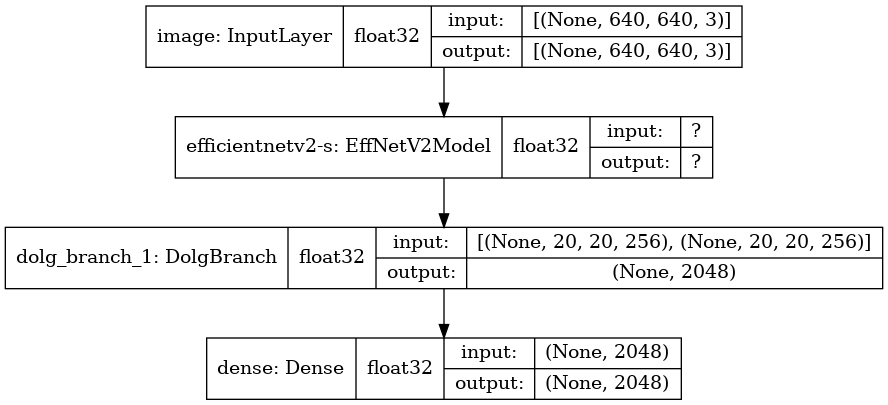

In [15]:
# The model outputs a descriptor of size 2048
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=False)

# Utility Functions

In [16]:
def show_batch(dataset, rows=5, cols=4):
    imgs, ids = next(iter(dataset))
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6, rows*6))
    for r in range(rows):
        for c in range(cols):
            idx = r*cols+c
            img = imgs[idx].numpy().astype(np.float32)
            img += abs(img.min())
            img /= img.max()
            axes[r, c].imshow(img)
            image_name = ids[idx]
            axes[r, c].set_title(f'image_name: {image_name}', size=12)

In [17]:
def decode_tfrecord(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    })

    image_name = tf.cast(features['image_name'], tf.string)
    
    image = tf.io.decode_jpeg(features['image'])
    # Resize Image
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Explicit reshape needed for TPU, tell cimpiler dimensions of image
    image = tf.reshape(image, INPUT_SHAPE)
        
    # ImageNet Normalization
    image = tf.cast(image, tf.float32)  / 255.0
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    
    return image, image_name

In [18]:
@tf.function(experimental_compile=True)
def predict_on_batch(images):
        return model(images, training=False)

# Train Dataset

In [19]:
def get_train_dataset(center_cutout=False):
    FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob(f'/kaggle/input/backfintfrecords/*train*.tfrec')
    
    train_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=1)
        
    train_dataset = train_dataset.map(decode_tfrecord, num_parallel_calls=cpu_count())
    train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
    train_dataset = train_dataset.prefetch(1)
    
    return train_dataset

In [20]:
images, image_ids = next(iter(get_train_dataset()))
print(f'images shape: {images.shape}, images dtype: {images.dtype}')
print(f'image_ids shape: {image_ids.shape}, image_ids dtype: {image_ids.dtype}')
img0 = images[0].numpy().astype(np.float32)
train_imgs_info = (img0.mean(), img0.std(), img0.min(), img0.max())
print('train img 0 mean: %.3f, 0 std: %.3f, min: %.3f, max: %.3f' % train_imgs_info)
print(f'first 5 image ids: {image_ids[:3].numpy().astype(str)}')

2022-04-09 00:08:07.983489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


images shape: (32, 640, 640, 3), images dtype: <dtype: 'float32'>
image_ids shape: (32,), image_ids dtype: <dtype: 'string'>
train img 0 mean: 0.405, 0 std: 1.055, min: -1.631, max: 2.640
first 5 image ids: ['c4188083259ede.jpg' 'dd3e33c974a779.jpg' 'dd461929cf2309.jpg']


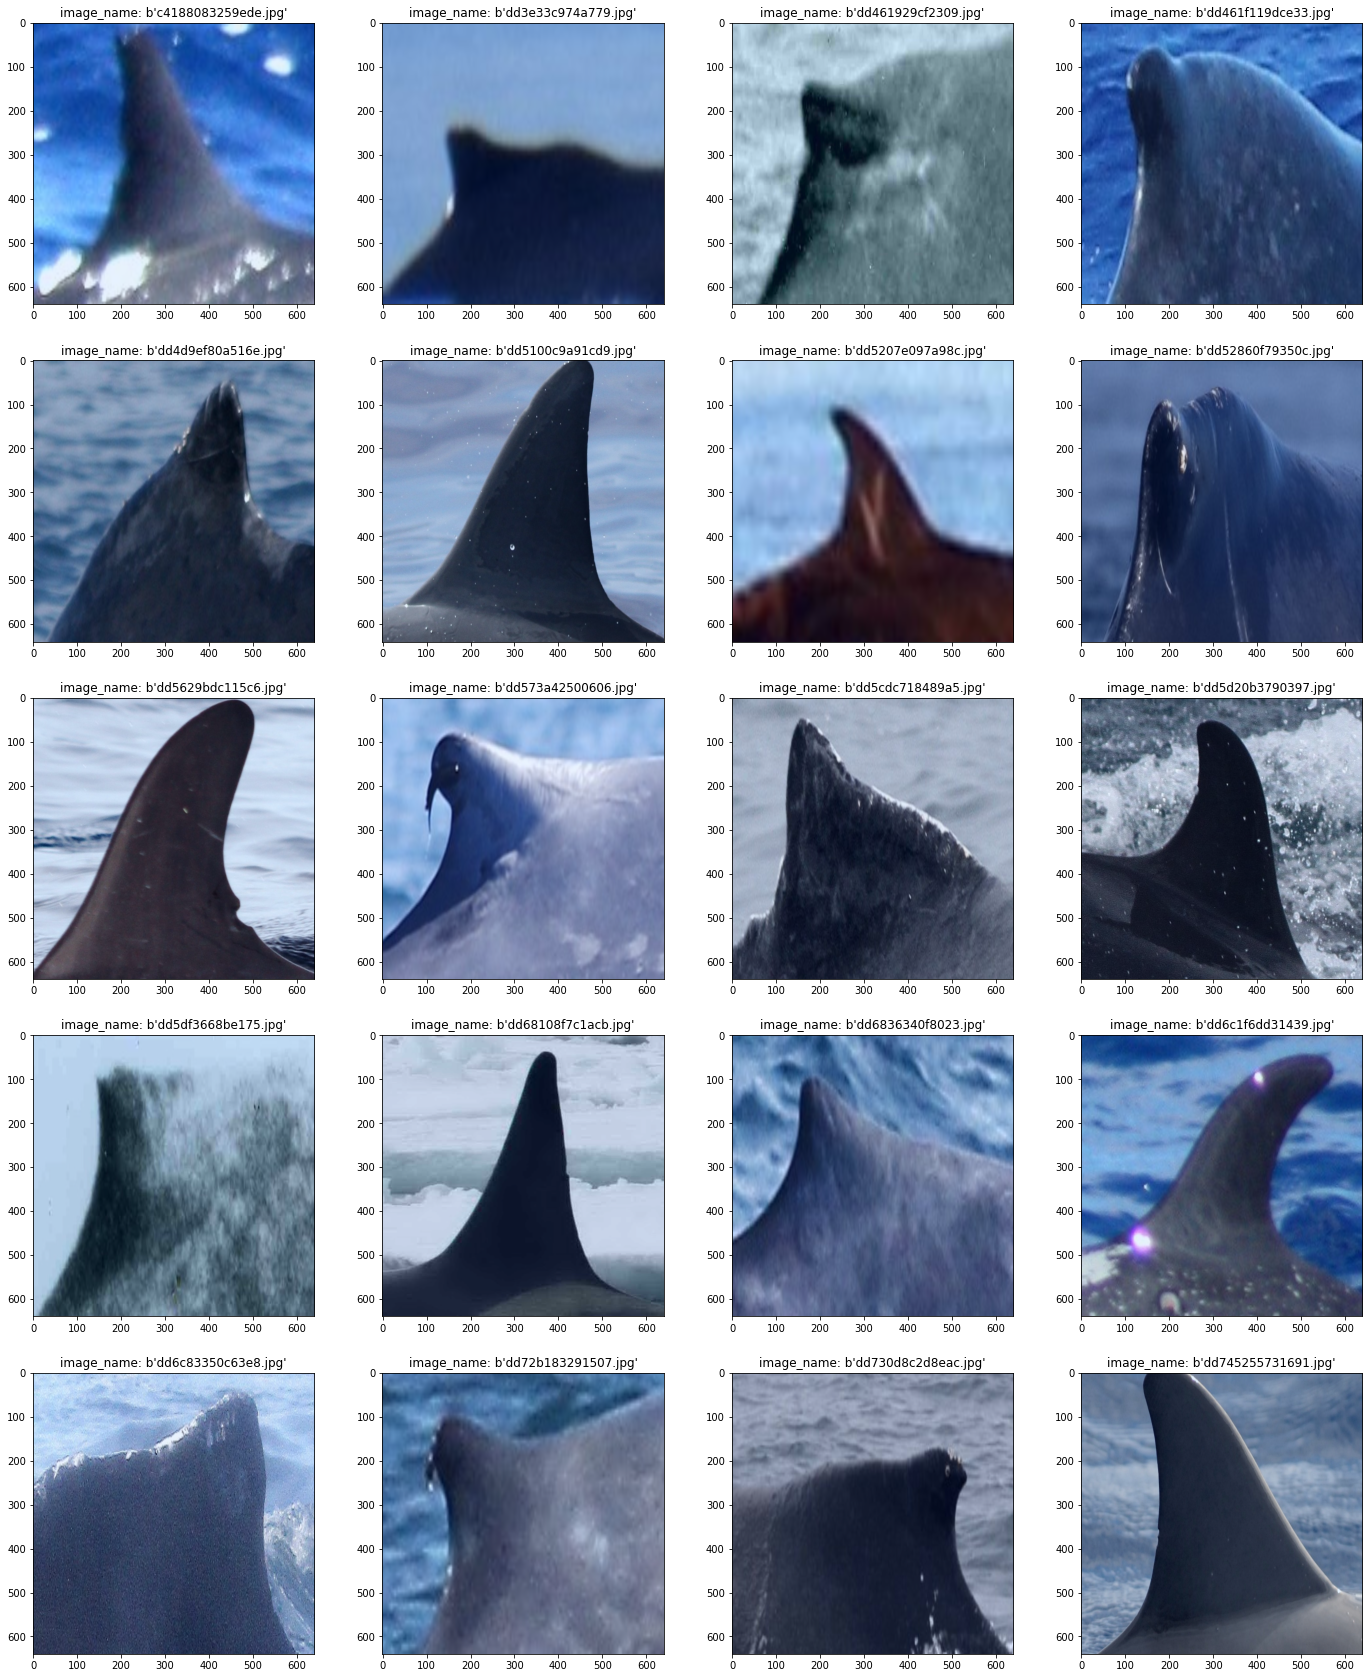

In [21]:
show_batch(get_train_dataset())

# Train Embeddings

Use the model to generate descriptors for all training images

In [22]:
N_TRAIN_SAMPLES = 41574
print(f'N_TRAIN_SAMPLES: {N_TRAIN_SAMPLES}, EMBEDDING_SIZE: {EMBEDDING_SIZE}')

N_TRAIN_SAMPLES: 41574, EMBEDDING_SIZE: 2048


In [23]:
if RECOMPUTE_EMBEDDINGS:
    TRAIN_EMBEDDINGS = np.zeros(shape=[N_TRAIN_SAMPLES, EMBEDDING_SIZE], dtype=np.float32)
    TRAIN_EMBEDDINGS_IDS = np.empty(shape=N_TRAIN_SAMPLES, dtype=object)
    
    total = math.ceil(N_TRAIN_SAMPLES / BATCH_SIZE)
    offset = 0

    for idx, (images, file_names) in enumerate(tqdm(get_train_dataset(), total=total)):
        start = offset
        end = offset + len(images)
        TRAIN_EMBEDDINGS[start:end] = predict_on_batch(images)
        TRAIN_EMBEDDINGS_IDS[start:end] = file_names.numpy().astype(str).tolist()
        offset += len(images)
else:
    TRAIN_EMBEDDINGS = np.load('/kaggle/input/happy-whale-2022-efficientnetv2-xl-dolg-inference/TRAIN_EMBEDDINGS.npy')
    TRAIN_EMBEDDINGS_IDS = np.load('/kaggle/input/happy-whale-2022-efficientnetv2-xl-dolg-inference/TRAIN_EMBEDDINGS_IDS.npy')
    
print(f'TRAIN_EMBEDDINGS shape: {TRAIN_EMBEDDINGS.shape}, dtype: {TRAIN_EMBEDDINGS.dtype}')
print(f'TRAIN_EMBEDDINGS_IDS shape: {TRAIN_EMBEDDINGS_IDS.shape}, dtype: {TRAIN_EMBEDDINGS_IDS.dtype}')

  0%|          | 0/1300 [00:00<?, ?it/s]

2022-04-09 00:08:25.539009: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55ee121945a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-04-09 00:08:25.539057: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2022-04-09 00:08:25.690099: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-04-09 00:08:28.315260: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-04-09 00:08:43.052952: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


TRAIN_EMBEDDINGS shape: (41574, 2048), dtype: float32
TRAIN_EMBEDDINGS_IDS shape: (41574,), dtype: object


In [24]:
TRAIN_EMBEDDINGS_TF = tf.constant(TRAIN_EMBEDDINGS)
TRAIN_EMBEDDINGS_IDS_TF = tf.constant(TRAIN_EMBEDDINGS_IDS)

In [25]:
# Save Train Embeddings
np.save('TRAIN_EMBEDDINGS.npy', TRAIN_EMBEDDINGS)
np.save('TRAIN_EMBEDDINGS_IDS.npy', TRAIN_EMBEDDINGS_IDS)

# Train Embeddings Analysis

In [26]:
TRAIN_EMBEDDINGS_SERIES = pd.Series(TRAIN_EMBEDDINGS.flatten())

In [27]:
display(TRAIN_EMBEDDINGS_SERIES.describe().to_frame(name='Value'))

Value
count  8.514355e+07
mean   2.662552e-03
std    1.370131e+00
min   -2.241094e+02
25%   -4.890985e-01
50%    6.253878e-04
75%    4.912008e-01
max    2.336266e+02

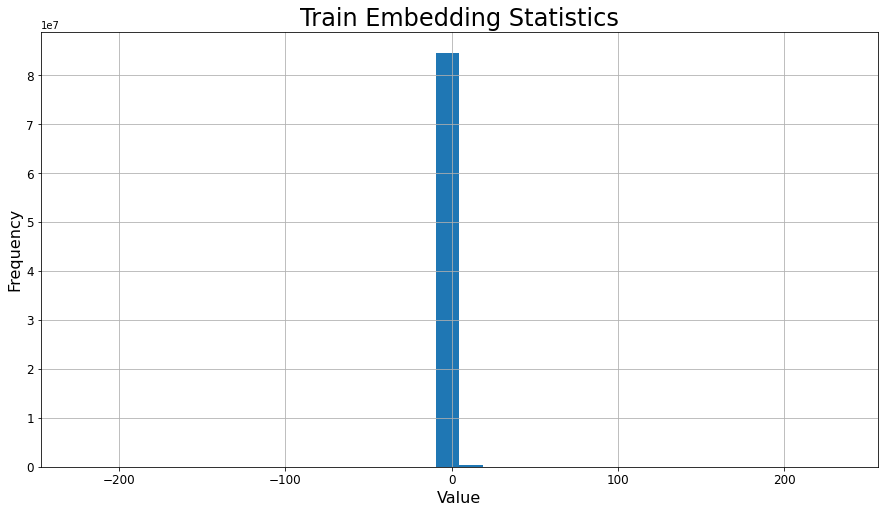

In [28]:
plt.figure(figsize=(15,8))
plt.title('Train Embedding Statistics', size=24)
TRAIN_EMBEDDINGS_SERIES.plot(kind='hist', bins=32)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Value', size=16)
plt.ylabel('Frequency', size=16)
plt.grid()
plt.show()

In [29]:
# Clean Up Numpy Train Arrays
del TRAIN_EMBEDDINGS, TRAIN_EMBEDDINGS_IDS, TRAIN_EMBEDDINGS_SERIES
gc.collect()

65571

# Test Dataset

In [30]:
def get_test_dataset(center_cutout=False):
    FNAMES_TEST_TFRECORDS = tf.io.gfile.glob(f'/kaggle/input/backfintfrecords/*test*.tfrec')
    
    test_dataset = tf.data.TFRecordDataset(FNAMES_TEST_TFRECORDS, num_parallel_reads=1)
        
    test_dataset = test_dataset.map(decode_tfrecord, num_parallel_calls=cpu_count())
    test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)
    test_dataset = test_dataset.prefetch(1)
    
    return test_dataset

In [31]:
images, image_ids = next(iter(get_test_dataset()))
print(f'images shape: {images.shape}, images dtype: {images.dtype}')
img0 = images[0].numpy().astype(np.float32)
train_imgs_info = (img0.mean(), img0.std(), img0.min(), img0.max())
print('train img 0 mean: %.3f, 0 std: %.3f, min: %.3f, max: %.3f' % train_imgs_info)
print(f'first 5 image ids: {image_ids[:3].numpy().astype(str)}')

images shape: (32, 640, 640, 3), images dtype: <dtype: 'float32'>
train img 0 mean: -0.341, 0 std: 0.740, min: -1.894, max: 2.640
first 5 image ids: ['0011f7a65044e4.jpg' '002c7034834e2c.jpg' '0039922e81961b.jpg']


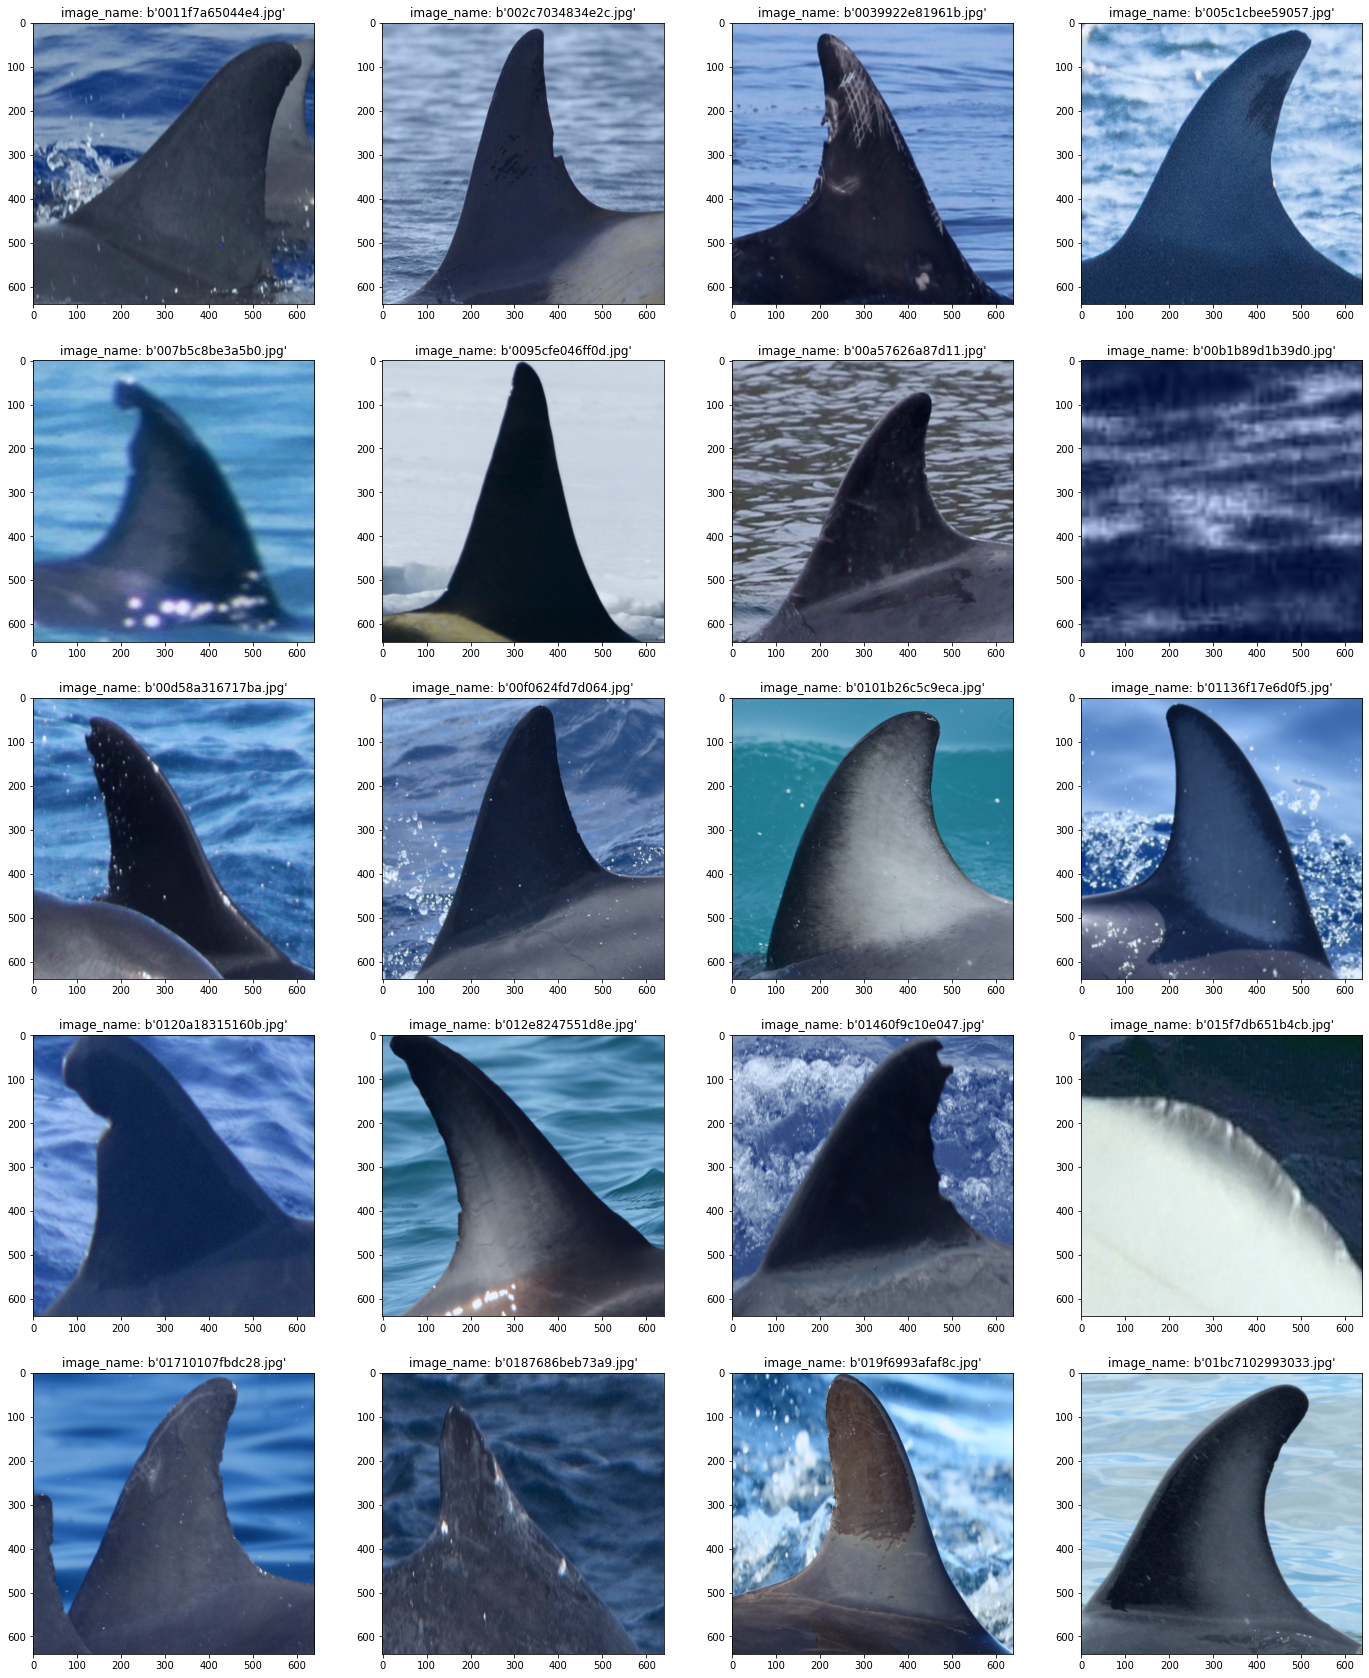

In [32]:
show_batch(get_test_dataset())

# Create Test Embeddings

Generate descriptors for all teste images

In [33]:
N_TEST_SAMPLES = len(glob.glob('/kaggle/input/happy-whale-and-dolphin/test_images/*.jpg'))
TEST_EMBEDDINGS = np.zeros(shape=[N_TEST_SAMPLES, EMBEDDING_SIZE], dtype=np.float32)
TEST_EMBEDDINGS_IDS = np.empty(shape=[N_TEST_SAMPLES], dtype=object)

total = math.ceil(N_TEST_SAMPLES / BATCH_SIZE)
offset = 0

for idx, (images, image_ids) in enumerate(tqdm(get_test_dataset(), total=total)):
    start = offset
    end = offset + len(images)
    TEST_EMBEDDINGS[start:end] = predict_on_batch(images)
    TEST_EMBEDDINGS_IDS[start:end] = image_ids.numpy().astype(str)
    offset += len(images)

  0%|          | 0/874 [00:00<?, ?it/s]

# Add Missing Images

Not all test images are included in the TFRecords. Missing test images are added with a fin crop given in [this](https://www.kaggle.com/c/happy-whale-and-dolphin/discussion/310153) discussion.

In [34]:
def get_bbox(bbox_str):
    if type(bbox_str) is not str:
        return []
    
    bbox = [int(s) for s in bbox_str.replace('[[', '').replace(']]', '').strip().split(' ') if len(s) > 0]
    
    return np.array([
        bbox[:2],
        [bbox[2], bbox[1]],
        bbox[2:],
        [bbox[0], bbox[3]],
    ])

In [35]:
def get_bbox_crop(img, bbox, scale=2, debug=False):
    if len(bbox) == 0:
        return img
    
    img_h, img_w = img.shape[:2]
    img_min = min(img_h, img_w)
    
    bbox_h0 = (bbox[2,1] - bbox[0,1])
    bbox_h = min(bbox_h0 * scale, img_min)
    bbox_w0 = (bbox[1,0] - bbox[0,0])
    bbox_w = min(bbox_w0 * scale, img_min)
    bbox_s = min(img_min, max(bbox_h, bbox_w))
    
    # Update bbox dimensions
    bbox_y = bbox[0,1]
    bbox_x = bbox[0,0]

    crop_y = max(0, bbox_y - (bbox_s - bbox_h0) // 2)
    crop_x = max(0, bbox_x - (bbox_s - bbox_w0) // 2)
    
    return img[crop_y:crop_y+bbox_s, crop_x:crop_x+bbox_s]

In [36]:
def process_image(file_path, bbox):
    img = imageio.imread(file_path)
    # Grayscale to RGB
    if len(img.shape) == 2:
        img = np.stack([img] * 3, axis=2)
        
    # Crop
    img = get_bbox_crop(img, bbox)
    
    h, w, _ = img.shape

    r = IMG_SIZE / min(w, h)
    
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LANCZOS4)
    
    img = img.astype(np.float32)  / 255.0
    img = (img - IMAGENET_MEAN) / IMAGENET_STD
    
    return img

In [37]:
test_fin_annotations = pd.read_csv('/kaggle/input/happy-whale-2022-fin-bounding-boxes/test_fin_annotations.csv')

# Add Bounding Box Coordinates
test_fin_annotations['bbox_np'] = test_fin_annotations['bbox'].apply(get_bbox)

TEST_EMBEDDINGS_IDS_SET = set(TEST_EMBEDDINGS_IDS)

for idx, row in tqdm(test_fin_annotations.iterrows(), total=N_TEST_SAMPLES):
    image_id = row['image_id']
    bbox_np = row['bbox_np']
    if image_id not in TEST_EMBEDDINGS_IDS_SET:
        print(f'Added image_id: {image_id}, bbox_np: {bbox_np}')
        image = process_image(row['image_path'], bbox_np)
        
        TEST_EMBEDDINGS[offset] = predict_on_batch(image[np.newaxis,:])
        TEST_EMBEDDINGS_IDS[offset] = image_id
        
        offset += 1

  0%|          | 0/27956 [00:00<?, ?it/s]

Added image_id: 22445a98cef357.jpg, bbox_np: []
Added image_id: 40c875d7fae0eb.jpg, bbox_np: []
Added image_id: 51be6c1c670d44.jpg, bbox_np: []
Added image_id: 57cadefa129e13.jpg, bbox_np: []
Added image_id: 6176e8b0e6afdc.jpg, bbox_np: []
Added image_id: 7a0434d332da07.jpg, bbox_np: []
Added image_id: 7c2cec53381645.jpg, bbox_np: []
Added image_id: 894b7488ed20cc.jpg, bbox_np: []
Added image_id: b345680ca03312.jpg, bbox_np: []
Added image_id: c633e5d93b8f5f.jpg, bbox_np: []
Added image_id: d32793e7caf213.jpg, bbox_np: []
Added image_id: dfccc5735c4023.jpg, bbox_np: [[  4   0]
 [240   0]
 [240   0]
 [  4   0]]
Added image_id: e792bda8f49156.jpg, bbox_np: []
Added image_id: e7be7505e80693.jpg, bbox_np: []


# Make Test Tensorflow Tensor

In [38]:
print(f'TEST_EMBEDDINGS shape: {TEST_EMBEDDINGS.shape}, dtype: {TEST_EMBEDDINGS.dtype}')
print(f'TEST_EMBEDDINGS_IDS shape: {TEST_EMBEDDINGS_IDS.shape}, dtype: {TEST_EMBEDDINGS_IDS.dtype}')

TEST_EMBEDDINGS shape: (27956, 2048), dtype: float32
TEST_EMBEDDINGS_IDS shape: (27956,), dtype: object


In [39]:
TEST_EMBEDDINGS_TF = tf.constant(TEST_EMBEDDINGS)
TEST_EMBEDDINGS_IDS_TF = tf.constant(TEST_EMBEDDINGS_IDS)

# Test Embeddings Analysis

In [40]:
TEST_EMBEDDINGS_SERIES = pd.Series(TEST_EMBEDDINGS.flatten())

In [41]:
display(TEST_EMBEDDINGS_SERIES.describe().to_frame(name='Value'))

Value
count  5.725389e+07
mean   1.558286e-03
std    7.728136e-01
min   -6.507517e+01
25%   -3.314728e-01
50%    1.207715e-03
75%    3.336841e-01
max    6.850231e+01

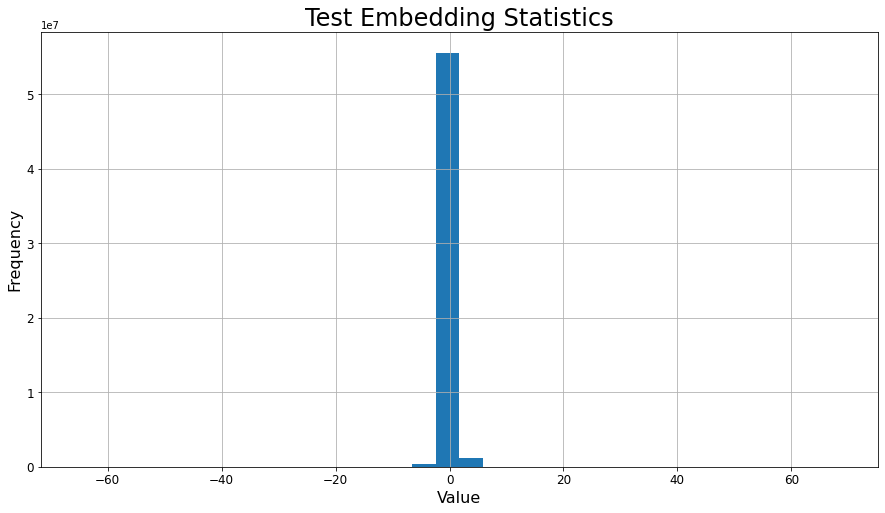

In [42]:
plt.figure(figsize=(15,8))
plt.title('Test Embedding Statistics', size=24)
TEST_EMBEDDINGS_SERIES.plot(kind='hist', bins=32)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Value', size=16)
plt.ylabel('Frequency', size=16)
plt.grid()
plt.show()

In [43]:
del TEST_EMBEDDINGS, TEST_EMBEDDINGS_IDS, TEST_EMBEDDINGS_SERIES
gc.collect()

64858

# File Name to Individual Id

In [44]:
train = pd.read_csv('/kaggle/input/happy-whale-and-dolphin/train.csv')
display(train.head())

image             species individual_id
0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9
1  000562241d384d.jpg      humpback_whale  1a71fbb72250
2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b
3  0007d9bca26a99.jpg  bottlenose_dolphin  4b00fe572063
4  00087baf5cef7a.jpg      humpback_whale  8e5253662392

In [45]:
# We need to predict the individual_id, not the file name
# This dictionary maps a file name to an individual id
file_name2individual_id = train[['image', 'individual_id']].set_index('image').squeeze().to_dict()

# Landmark Predictions and Confidence

In [46]:
@tf.function(experimental_compile=False)
def get_pred(query, k=1000):
    # Expand dims and tile test descriptor
    query_tile = tf.expand_dims(query, axis=0)
    query_tile = tf.tile(input=query_tile, multiples=[N_TRAIN_SAMPLES, 1])
    # Compute cosine similarity between test descriptor and all train descriptors
    cors = -1.0 * tf.keras.losses.cosine_similarity(query_tile, TRAIN_EMBEDDINGS_TF)
    # Retrieve the indices and correlations of the top 100 train descriptors
    cors_pred, indices = tf.math.top_k(cors, k=k)
    # Get the file names of the top 100 most similar train images
    labels_pred = tf.gather(TRAIN_EMBEDDINGS_IDS_TF, indices)
    
    return labels_pred, cors_pred

# Prediction

In [47]:
# Raw labels and correlations to actual individual_id prediction string
def get_nunique(labels_pred, cors_pred, k=5):
    # Dictionary to keep track of individual_ids and summed correlation
    individual_ids_dict = {}
    # Loop over labels and correlations
    for l, c in zip(labels_pred, cors_pred):
        # Map label to individual_id
        individual_id = file_name2individual_id.get(l)
        # If individual_id is not in dictionary add it with correlation
        if individual_id not in individual_ids_dict:
            individual_ids_dict[individual_id] = c
        # If individual_id is in dictionary add correlation
        else:
            individual_ids_dict[individual_id] += c
        
        # If 5 unique individual_ids are found stop
        if len(individual_ids_dict.keys()) == k:
            break
        
    # Make prediction string
    predictions = ' '.join(list(individual_ids_dict.keys()))
    # Make list of summed correlations per individual_id
    individual_id_cors = list(individual_ids_dict.values())
            
    return predictions, individual_id_cors

# Actual Prediction Loop

In [48]:
df_dicts = []
score_list = []
test_nl_score_list = []
cors_max_list = []
for idx, (query, image_id) in tqdm(enumerate(zip(TEST_EMBEDDINGS_TF, TEST_EMBEDDINGS_IDS_TF)), total=N_TEST_SAMPLES):
    # Top 1000 most similar train file names and cosine similarities
    labels_pred, cors_pred = get_pred(query)
    # Convert labels and correlations to prediction string and summed correlation
    labels_pred = labels_pred.numpy().astype(str)
    
    # Maximum Correlation
    cors_pred = cors_pred.numpy()
    c_max = cors_pred.max()
    cors_max_list.append(c_max)
    
    # Get top 5 unique predictions and summed correlation
    predictions, individual_id_cors = get_nunique(labels_pred, cors_pred)
    
    # image_id to string
    image_id = image_id.numpy().decode()

    # Append Prediction dictionary
    df_dicts.append({
        'image': image_id,
        'predictions': predictions,
        'correlations': individual_id_cors,
        'cors_max': c_max,
    })

  0%|          | 0/27956 [00:00<?, ?it/s]

2022-04-09 00:35:47.239698: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1652] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


# Correlation Analysis

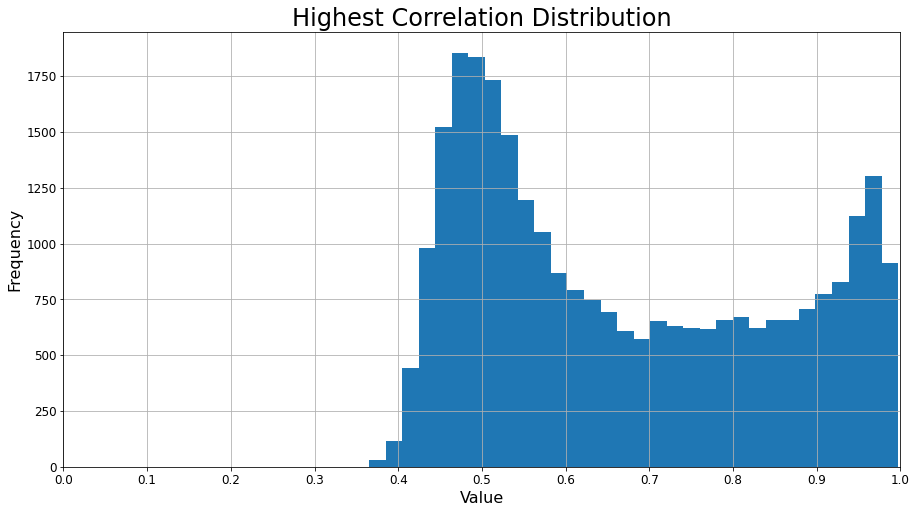

In [49]:
# Maximum correlation distribution
plt.figure(figsize=(15,8))
plt.title('Highest Correlation Distribution', size=24)
pd.Series(cors_max_list).plot(kind='hist', bins=32)
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.1, 0.1), size=12)
plt.yticks(size=12)
plt.xlabel('Value', size=16)
plt.ylabel('Frequency', size=16)
plt.grid()
plt.show()

# Introduce New Individuals

In [50]:
# Threshold for adding "new individual" is based on N-th percentile of maximum correlation
cors_percentile = np.percentile(cors_max_list, NEW_INDIVIDUAL_PERCENTILE)
print(f'cors_percentile: {cors_percentile:.2f}')

cors_percentile: 0.54


In [51]:
# Add new individual if maximum correlation is below threshold
for v in df_dicts:
    if v['cors_max'] < cors_percentile:
        v['predictions'] = 'new_individual ' + ' '.join(v['predictions'].split(' ')[:-1])

# Save Submission

In [52]:
# Create submission Pandas DataFrame
submission = pd.DataFrame.from_dict(df_dicts).sort_values('image')

In [53]:
display(submission.head(10))

image                                        predictions  \
19557  000110707af0ba.jpg  new_individual ed12e6721cc7 0f386614bfdc fe61b...   
13975  0006287ec424cb.jpg  1424c7fec826 c3b7d902e73c e72a5024c4ad ff69d09...   
5589   000809ecb2ccad.jpg  new_individual c295e46e85d8 e96ac943cbef eac1f...   
22352  00098d1376dab2.jpg  c4274d90be60 8b7c29052b93 1ae5c5a035b5 2f2e8ad...   
2794   000b8d89c738bd.jpg  cf500d3874bc ef2bf7f7553d 56637d420170 a8bdd2b...   
25147  000e246888710c.jpg  new_individual 89edacf95765 5652d70e442c 28bf5...   
11180  000eb6e73a31a5.jpg  77410a623426 46414154efbc 18dbd44823c7 02947a9...   
16767  000fe6ebfc9893.jpg  8805324885f2 75e91d83d5a8 fc7a95265542 7b5d5d5...   
0      0011f7a65044e4.jpg  15c33313cdad d5dcbb35777c 1e377a7f2e3c 21f2f1b...   
8385   0012ff300032e3.jpg  c80b3f91d4d1 8e8decebac52 74f953c8a912 5ee2311...   

                                            correlations  cors_max  
19557  [0.96786237, 0.46478358, 0.42482638, 0.4108498...  0.494822  
13975  [30.418867, 3.818509, 0.5032933, 0.49134773, 0...  0.838040  
5589   [2.2533169, 0.43790585, 0.43774825, 0.43594733...  0.478409  
22352  [13.648056, 5.5343037, 4.2223034, 0.5321804, 0...  0.944387  
2794   [0.58578455, 0.4873017, 0.8871267, 0.44572586,...  0.585785  
25147  [2.7106128, 0.42665678, 0.42074665, 0.83846927...  0.482175  
11180  [71.81237, 3.8655713, 0.55877316, 0.544785, 0....  0.936080  
16767  [5.560987, 1.7860909, 0.43945295, 0.43427223, ...  0.953774  
0      [1.0819569, 0.46768528, 0.46628752, 0.46522158...  0.548249  
8385   [0.55710727, 0.45107532, 0.42062262, 0.4106479...  0.557107

In [54]:
display(submission.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27956 entries, 19557 to 27941
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         27956 non-null  object 
 1   predictions   27956 non-null  object 
 2   correlations  27956 non-null  object 
 3   cors_max      27956 non-null  float32
dtypes: float32(1), object(3)
memory usage: 982.8+ KB


None

In [55]:
# Save Submission as CSV
submission[['image', 'predictions']].to_csv('submission.csv', index=False)

In [56]:
n_unique_predictions = submission['predictions'].str.split().apply(set).apply(len)

# Count of Unique Individual IDs per Prediction [test whether all 5]
display(n_unique_predictions.value_counts().sort_index().to_frame(name='count'))
# Ratio of Unique Individual IDs per Prediction [test whether 100% 5]
display(n_unique_predictions.value_counts(normalize=True).sort_index().to_frame(name='ratio'))

count
5  27956

ratio
5    1.0

In [57]:
from sklearn.manifold import TSNE
embeddings = TSNE(n_components=2,init = 'pca').fit_transform(TRAIN_EMBEDDINGS_TF)
sns.scatterplot(x=embeddings[:,0],y=embeddings[:,1],hue= labels ,legend='full')

NameError: name 'sns' is not defined